In [1]:
# pip install transformers datasets

     ---------------------------------------- 0.0/44.1 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.1 kB 640.0 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 44.1/44.1 kB 360.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 764.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/69.9 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/69.9 kB ? eta -:--:--
     ---------------- --------------------- 30.7/69.9 kB 640.0 kB/s eta 0:00:01
     --------------------------------- ---- 61.4/69.9 kB 544.7 kB/s eta 0:00:01


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

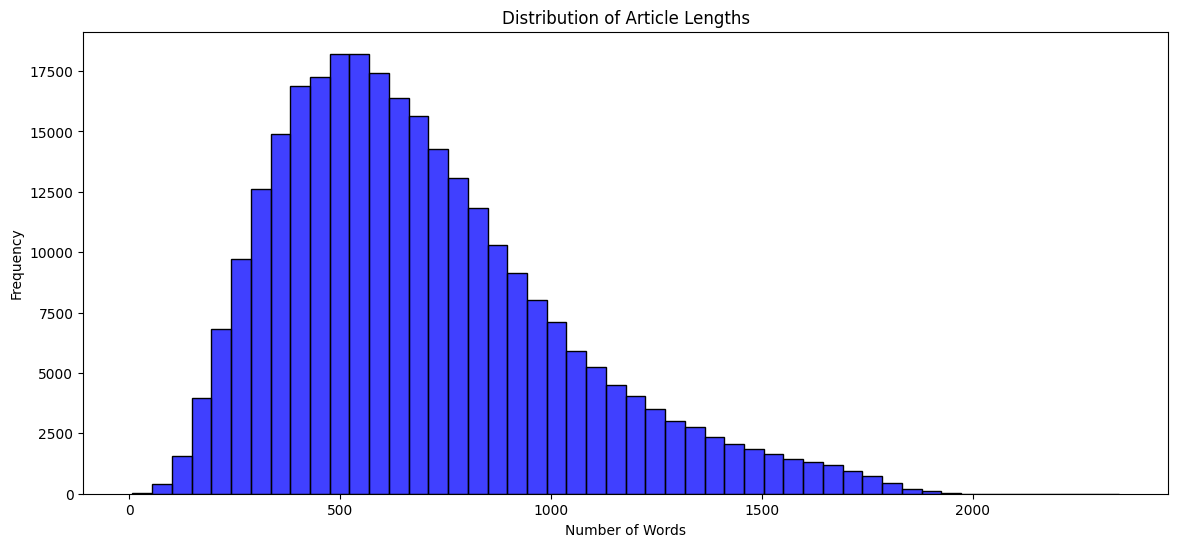

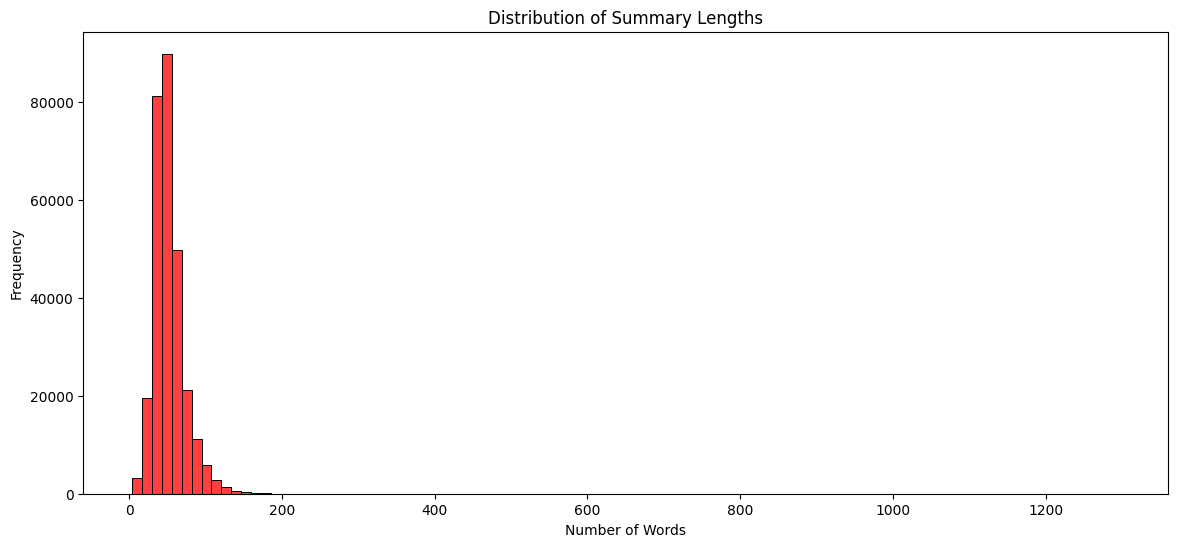

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


# Compute lengths
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

# Plotting Article Lengths
plt.figure(figsize=(14, 6))
sns.histplot(article_lengths, bins=50, color='blue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plotting Summary Lengths
plt.figure(figsize=(14, 6))
sns.histplot(summary_lengths, bins=100, color='red')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

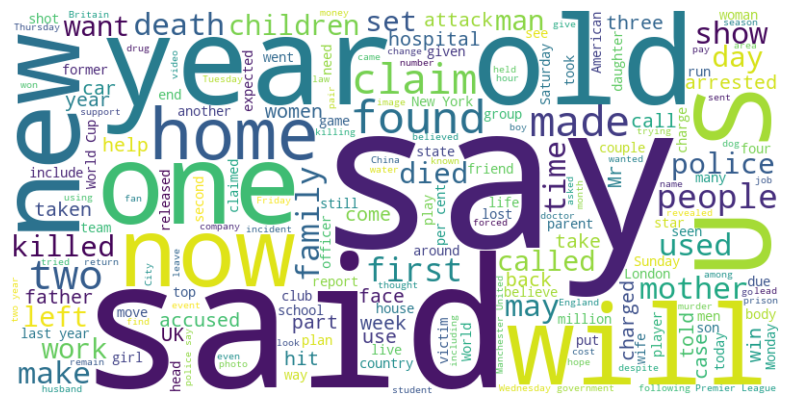

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all summaries
text = " ".join(summary for summary in dataset['train']['highlights'])

# Optionally, you can clean the text (remove stopwords, punctuation, etc.)
# For example:
# text = clean_text_function(text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Disable axis
plt.show()


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('lucadiliello/bart-small')
model = BartForConditionalGeneration.from_pretrained('lucadiliello/bart-small', ignore_mismatched_sizes=True)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [5]:
def preprocess_function(examples):
    # Tokenize the articles and summaries (highlights)
    inputs = tokenizer(examples['article'], padding='max_length', truncation=True, max_length=512)
    labels = tokenizer(examples['highlights'], padding='max_length', truncation=True, max_length=150)

    # Ensure that labels are correctly aligned with the input format
    inputs['labels'] = labels['input_ids']
    return inputs


# Apply the preprocessing function to the dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [7]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(  
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',
    report_to="none",
    save_steps=500,
    save_total_limit=3, 
    remove_unused_columns=False,
    load_best_model_at_end=True,
    eval_strategy="steps",
    eval_steps=500,
)

# Initialize Trainer
trainer = Trainer(
    model=model.to('cuda:0'),
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

In [8]:
trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
c:\Users\vishn\OneDrive\Desktop\GUI\creategui\Lib\site-packages\transformers\trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

  0%|          | 0/215337 [00:00<?, ?it/s]

c:\Users\vishn\OneDrive\Desktop\GUI\creategui\Lib\site-packages\transformers\trainer.py:3033: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = torch.load

{'loss': 1.0714, 'grad_norm': 4.0296101570129395, 'learning_rate': 4.022514743735949e-05, 'epoch': 0.59}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0844265222549438, 'eval_runtime': 429.3998, 'eval_samples_per_second': 31.132, 'eval_steps_per_second': 7.783, 'epoch': 0.59}


c:\Users\vishn\OneDrive\Desktop\GUI\creategui\Lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'loss': 1.0869, 'grad_norm': 3.0267605781555176, 'learning_rate': 4.01087801449471e-05, 'epoch': 0.6}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0878115892410278, 'eval_runtime': 429.9898, 'eval_samples_per_second': 31.089, 'eval_steps_per_second': 7.772, 'epoch': 0.6}
{'loss': 1.0814, 'grad_norm': 4.2175798416137695, 'learning_rate': 3.999241285253472e-05, 'epoch': 0.61}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0977683067321777, 'eval_runtime': 430.805, 'eval_samples_per_second': 31.03, 'eval_steps_per_second': 7.758, 'epoch': 0.61}
{'loss': 1.0768, 'grad_norm': 3.38568377494812, 'learning_rate': 3.987604556012233e-05, 'epoch': 0.61}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0924077033996582, 'eval_runtime': 429.801, 'eval_samples_per_second': 31.103, 'eval_steps_per_second': 7.776, 'epoch': 0.61}
{'loss': 1.0401, 'grad_norm': 3.299668073654175, 'learning_rate': 3.975967826770994e-05, 'epoch': 0.62}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.087636947631836, 'eval_runtime': 429.3232, 'eval_samples_per_second': 31.137, 'eval_steps_per_second': 7.784, 'epoch': 0.62}
{'loss': 1.1001, 'grad_norm': 3.516321897506714, 'learning_rate': 3.9643310975297555e-05, 'epoch': 0.63}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0847859382629395, 'eval_runtime': 429.5801, 'eval_samples_per_second': 31.119, 'eval_steps_per_second': 7.78, 'epoch': 0.63}
{'loss': 1.0789, 'grad_norm': 3.183182954788208, 'learning_rate': 3.9526943682885166e-05, 'epoch': 0.63}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0856722593307495, 'eval_runtime': 429.3302, 'eval_samples_per_second': 31.137, 'eval_steps_per_second': 7.784, 'epoch': 0.63}
{'loss': 1.0636, 'grad_norm': 3.7037642002105713, 'learning_rate': 3.941057639047278e-05, 'epoch': 0.64}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.091772198677063, 'eval_runtime': 428.379, 'eval_samples_per_second': 31.206, 'eval_steps_per_second': 7.802, 'epoch': 0.64}
{'loss': 1.0866, 'grad_norm': 3.0096096992492676, 'learning_rate': 3.929420909806039e-05, 'epoch': 0.65}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0848814249038696, 'eval_runtime': 429.4829, 'eval_samples_per_second': 31.126, 'eval_steps_per_second': 7.781, 'epoch': 0.65}
{'loss': 1.0871, 'grad_norm': 3.515195369720459, 'learning_rate': 3.9177841805648e-05, 'epoch': 0.65}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0840944051742554, 'eval_runtime': 428.9364, 'eval_samples_per_second': 31.165, 'eval_steps_per_second': 7.791, 'epoch': 0.65}
{'loss': 1.0806, 'grad_norm': 3.1640279293060303, 'learning_rate': 3.906147451323562e-05, 'epoch': 0.66}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0848863124847412, 'eval_runtime': 429.3178, 'eval_samples_per_second': 31.138, 'eval_steps_per_second': 7.784, 'epoch': 0.66}
{'loss': 1.0767, 'grad_norm': 3.8574957847595215, 'learning_rate': 3.894510722082323e-05, 'epoch': 0.67}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0842393636703491, 'eval_runtime': 505.6436, 'eval_samples_per_second': 26.438, 'eval_steps_per_second': 6.609, 'epoch': 0.67}
{'loss': 1.0778, 'grad_norm': 3.3608593940734863, 'learning_rate': 3.882873992841085e-05, 'epoch': 0.68}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0816506147384644, 'eval_runtime': 596.0672, 'eval_samples_per_second': 22.427, 'eval_steps_per_second': 5.607, 'epoch': 0.68}
{'loss': 1.072, 'grad_norm': 3.104728937149048, 'learning_rate': 3.871237263599846e-05, 'epoch': 0.68}


  0%|          | 0/3342 [00:00<?, ?it/s]

{'eval_loss': 1.0839099884033203, 'eval_runtime': 593.2618, 'eval_samples_per_second': 22.533, 'eval_steps_per_second': 5.633, 'epoch': 0.68}
{'loss': 1.0632, 'grad_norm': 3.8183321952819824, 'learning_rate': 3.859600534358607e-05, 'epoch': 0.69}


  0%|          | 0/3342 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(model.config.vocab_size)

50264


In [34]:

# Tokenize a sample input
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
print("Input IDs:", inputs['input_ids'])

# Check token IDs range
vocab_size = tokenizer.vocab_size
print("Vocab Size:", vocab_size)
if (inputs['input_ids'] >= vocab_size).any():
    raise ValueError("Some token IDs are out of range")

Input IDs: tensor([[    0, 31414,     6,   141,    32,    47,   116,     2]])
Vocab Size: 50265
